# Homework set 3

(Due Mar 3., 2023 at Noon)

Submit your solution notebook in your directory via github PR.

## Problem 1 (100 pts)

Our Colloquium speaker a couple of weeks ago, Ashley Villar, has had to use MCMC extensively. She had something like 5,243 objects from Pan-STARRS to analyze after all (https://zenodo.org/record/3974950)

You'll only have to deal with two - the two that are in this directory

In [1]:
!ls *snana.dat

PS1_PS1MD_PSc000098.snana.dat  PS1_PS1MD_PSc000174.snana.dat


She used equation 1, defined here: https://arxiv.org/abs/1905.07422

# $ F= \begin{cases}\frac{A+\beta\left(t-t_0\right)}{1+e^{-\left(t-t_0\right) / \tau_{\text {rise }}}} & t<t_1 \\ \frac{\left(A+\beta\left(t_1-t_0\right)\right) e^{-\left(t-t_1\right) / \tau_{\text {fall }}}}{1+e^{-\left(t-t_0\right) / \tau_{\text {rise }}}} & t \geq t_1\end{cases} $

to model the *flux*, $F$, of a supernova in some band, at times, $t$.

You can see the fits Ashley derived here:

<img src="examples.jpg">

As Bayesian's we have 4 questions to answer

    What's the model?
    What's the Likelihood?
    What's the Prior?
    How do you sample?

I've tell you 1 (eqn. 1 in Villar). and you've already guessed 4 (use `emcee`: https://emcee.readthedocs.io/en/stable/). 

Write some functions to implement the model, likelihood and priors, and use `emcee` to sample the posterior with 20 walkers and however many steps you feel is necessary for the burn-in and chain. (50 pts - 15 each for the model, likelihood, priors and 5 to sample) 
 
Show that the posterior is reasonable by generating a corner plot with the `corner` package. (10 pts)

Get the median estimate for each parameter, and recreate the plot above from Ashley. Note that she's made 5 random draws from the chain for each passband to give the reader a sense for the uncertainties. (25 pts)

Report the auto-correlation length of your chain. Thin it by a factor of 10 and report the auto-correlation length again. (15 pts)

In [2]:
%matplotlib inline

import numpy as np
import emcee

from astropy.table import Table
from numba import njit
from multiprocessing import Pool

import corner
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

### Get data

In [3]:
#Class I'm using to hold data, get data from certain bands, and filter the data only near the peak
class Supernova():
    
    def __init__(self, obj):
        if obj == 0:
            filename = 'PS1_PS1MD_PSc000098.snana.dat'
            objname = 'PSc000098'
        if obj == 1:
            filename = 'PS1_PS1MD_PSc000174.snana.dat'
            objname = 'PSc000174'
        
        x, band, y, yerr = extract_data(filename)
        self.bands = band
        self.dat = np.vstack([x, y, yerr])
        self.obj = obj
        self.objname = objname
        
        self.current_band = None

        
    def get_band(self, band):
        good_ind = np.argwhere( self.bands == band ).T[0]
        
        self.current_band = band
        self.x_band = self.dat[0, good_ind]
        self.y_band = self.dat[1, good_ind]
        self.yerr_band = self.dat[2, good_ind]
        
        
    #Cut the data to only include data near the peak (and some data before and after to help with calculating the baseline)
    #This differs per band and per object
    def cut_times(self, band=None):
        
        if self.current_band is None:
            self.get_band(band)
            self.current_band = band
        
        if self.current_band == 'g':
            ind = 0
        elif self.current_band == 'r':
            ind = 1
        elif self.current_band == 'i':
            ind = 2
        elif self.current_band == 'z':
            ind = 3
        
        if self.obj == 0:
            x1_vals = [0, 0, 54970, 54970]
            x2_vals = [55620, 55650, 55650, 55640]
        elif self.obj == 1:
            x1_vals = [0, 0, 0, 55165]
            x2_vals = [55400, 55400, 55600, 55600]

        
        good_ind = np.argwhere( (self.x_band > x1_vals[ind]) & (self.x_band < x2_vals[ind]) ).T[0]
        self.x_band = self.x_band[good_ind]
        self.y_band = self.y_band[good_ind]
        self.yerr_band = self.yerr_band[good_ind]

        
        
def extract_data(filename):

    dat = Table.read(filename, format='ascii', header_start=None, data_start=12, data_end=-1)

    x = dat['col2']
    band = dat['col3']
    y = dat['col5']
    yerr = dat['col6']


    nan_ind1 = np.isnan(y)
    nan_ind2 = np.isnan(yerr)
    x = x[(~nan_ind1)&(~nan_ind2)]
    band = band[(~nan_ind1)&(~nan_ind2)]
    y = y[(~nan_ind1)&(~nan_ind2)]
    yerr = yerr[(~nan_ind1)&(~nan_ind2)]

    return x, band, y, yerr

### Setup model

In [4]:
#Model
@njit #Use numba to speed things up
def flux_model(t, theta):
    #Include the parameter to adjust the baseline flux (c) to help with fits
    
    a, beta, t0, gamma, trise, tfall, c = theta
    t1 = gamma + t0


    less_mask = t < t1
    flux_vals = np.zeros_like(t)

    #For t < t1
    t_i = t[less_mask]
    term1 = a + beta*(t_i-t0)
    term2 = 1 + np.exp( -(t_i-t0)/trise )
    flux_vals[less_mask] = (term1/term2) + c

    #For t >= t1
    t_i = t[~less_mask]
    term1 = ( a + beta*(t1-t0) )*np.exp( -(t_i-t1)/tfall )
    term2 = 1 + np.exp( -(t_i-t0)/trise )
    flux_vals[~less_mask] = (term1/term2) + c

    return flux_vals



#Likelihood
def log_likelihood(theta, sn, sigma_N=None):

    loglike = 0
    nparam = len(theta)//4
    
    for i, band in enumerate('griz'):
        sn.get_band(band)
        sn.cut_times()
        
        #Residuals
        #Use nan_to_num because the model will output NaNs sometimes (probably the exponentials blowing up)
        dy = sn.y_band - np.nan_to_num( flux_model(sn.x_band, theta[i*nparam:(i+1)*nparam]) )
        if sigma_N is None:
            sigma_N = 0

        sigma_tot = np.sqrt(sigma_N**2 + sn.yerr_band**2)

        #Make the likelihood gaussian
        loglike += np.sum( - np.log(sigma_tot) -.5*np.log(2*np.pi) - dy**2/sigma_tot**2/2 )

    return loglike





#Prior
def uniform_logpdf(x, a, b):
    if (x > a) & (x < b):
        return -np.log(b-a)
    else:
        return -np.inf

def norm_logpdf(x, mu, sigma):
    return - np.log(sigma) - .5*np.log(2*np.pi) - (x-mu)**2/sigma**2/2

def gamma_prior_logpdf(x, mu1, mu2, sig1, sig2):
    p1 = np.exp(norm_logpdf(x, mu1, sig1))
    p2 = np.exp(norm_logpdf(x, mu2, sig2))
    return np.log( 2*p1/3 + p2/3 )



def log_prior(theta, sn):

    nparam = len(theta)//4


    log_prior_tot = 0
    for i, band in enumerate('griz'):
        #Use (some of) the definitions for priors in Villar

        sn.get_band(band)
        sn.cut_times()

        fmax = np.max(sn.y_band)
        tmin = np.min(sn.x_band)
        tmax = np.max(sn.x_band)
        theta_i = theta[i*nparam:(i+1)*nparam]




        #For A: U(Fmax/2, 2*F_max)
        log_prior_tot += uniform_logpdf(theta_i[0], fmax/2, 2*fmax)

        #For beta: U(-F_max/150, 0)
        log_prior_tot += uniform_logpdf(theta_i[1], -fmax/150, 0)

        #For t0: N(t_{Fmax}, 30)
        max_ind = np.argmax(sn.y_band)
        t_fmax = sn.x_band[max_ind]
        log_prior_tot += norm_logpdf(theta_i[2], t_fmax, 20)

        #For gamma: (2/3)N(5,5) + (1/3)N(60,30)
        log_prior_tot += gamma_prior_logpdf(theta_i[3], 5, 60, 5, 30)

        #For trise: U(.01, 50)
        log_prior_tot += uniform_logpdf(theta_i[4], .01, 50)

        #For tfall: U(1, 300)
        log_prior_tot += uniform_logpdf(theta_i[5], 1, 300)
        
        #For c: U(-50, 50)
        log_prior_tot += uniform_logpdf(theta_i[6], -50, 50)

    return log_prior_tot


#Posterior
def log_posterior(theta, sn):

    lpri = log_prior(theta, sn)
    llik = log_likelihood(theta, sn)

    return lpri + llik

Priors I'm using:

$A \sim U(0.5F_{max}, 2F_{max})$

$\beta \sim U(-F_{max}/150, 0)$*

$t_0 \sim N(t_{F_{max}}, 20)$ -  where $t_{F_{max}}$ is the $t$ value at $F_{max}$

$\gamma \sim (2/3)N(5,5) + (1/3)N(60,30)$*

$t_{rise} \sim U(0.01, 50)$*

$t_{fall} \sim U(1, 300)$*

$c \sim U(-25, 25)$

Priors with * are taken directly from Villar.

### Run Sampling

In [5]:
def gamma_prior_sample(size):

    pvals = np.random.uniform(0,1, size)
    output = np.zeros(size)


    mask = pvals < 2/3
    good_ind = np.argwhere(mask).T[0]
    output[good_ind] = np.random.normal(5,5, size=len(good_ind))

    bad_ind = np.argwhere(~mask).T[0]
    output[bad_ind] = np.random.normal(60,30, size=len(bad_ind))

    return np.array(output)


def get_guesses(sn, nwalker, ndim):

    guesses = np.zeros((nwalker, ndim))
    nparam = ndim//4
    
    for i, band in enumerate('griz'):
        sn.get_band(band)
        sn.cut_times()
        
        m = nparam*i

        #Get random guesses
        guesses[:,m] = np.random.uniform(np.max(sn.y_band)/2, 2*np.max(sn.y_band), nwalker)
        guesses[:,m+1] = np.random.uniform(-np.max(sn.y_band)/150, 0, nwalker)
        
        max_ind = np.argmax(sn.y_band)
        t_fmax = sn.x_band[max_ind]
        guesses[:,m+2] = np.random.normal(t_fmax, 20, nwalker)
        
        guesses[:,m+3] = gamma_prior_sample(nwalker)
        guesses[:,m+4] = np.random.uniform(.01, 50, nwalker)
        guesses[:,m+5] = np.random.uniform(1, 300, nwalker)
        guesses[:,m+6] = np.random.uniform(-50, 50, nwalker)

    return guesses


def run_sampling(sn, output_fname, nchain, nwalker):

    ndim = 4*7
    guesses = get_guesses(sn, nwalker, ndim)
    
    #Use multiple CPUs to speed up
    with Pool(40) as pool:
        sampler = emcee.EnsembleSampler(nwalker, ndim, log_posterior, args=[sn], pool=pool)
        _ = sampler.run_mcmc(guesses, nchain, progress=True)

    sample = sampler.get_chain()
    np.savez(output_fname, sample)

    return sampler

In [6]:
#Sampling
nchain = 20000

#emcee won't run if I don't use more walkers, so I'm using 20 walkers per band
nwalker = 20*4

all_samplers = []
all_sn = []
for i in range(2):
    sn = Supernova(i)
    sampler = run_sampling(sn, 'mcmc_sample' + str(i), nchain, nwalker)
    
    all_sn.append(sn)
    all_samplers.append(sampler)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [07:40<00:00, 43.47it/s]


In [7]:
titles_tot = []

for b in 'griz':
    titles = [r'$A_'+b+'$', r'$\beta_'+b+'$', r'$t_{0,'+b+'}$', r'$\gamma_'+b+'$', r'$t_{rise,'+b+'}$', r'$t_{fall,'+b+'}$', r'$c_'+b+'$']
    titles_tot.append(titles)
    

### Trace plot

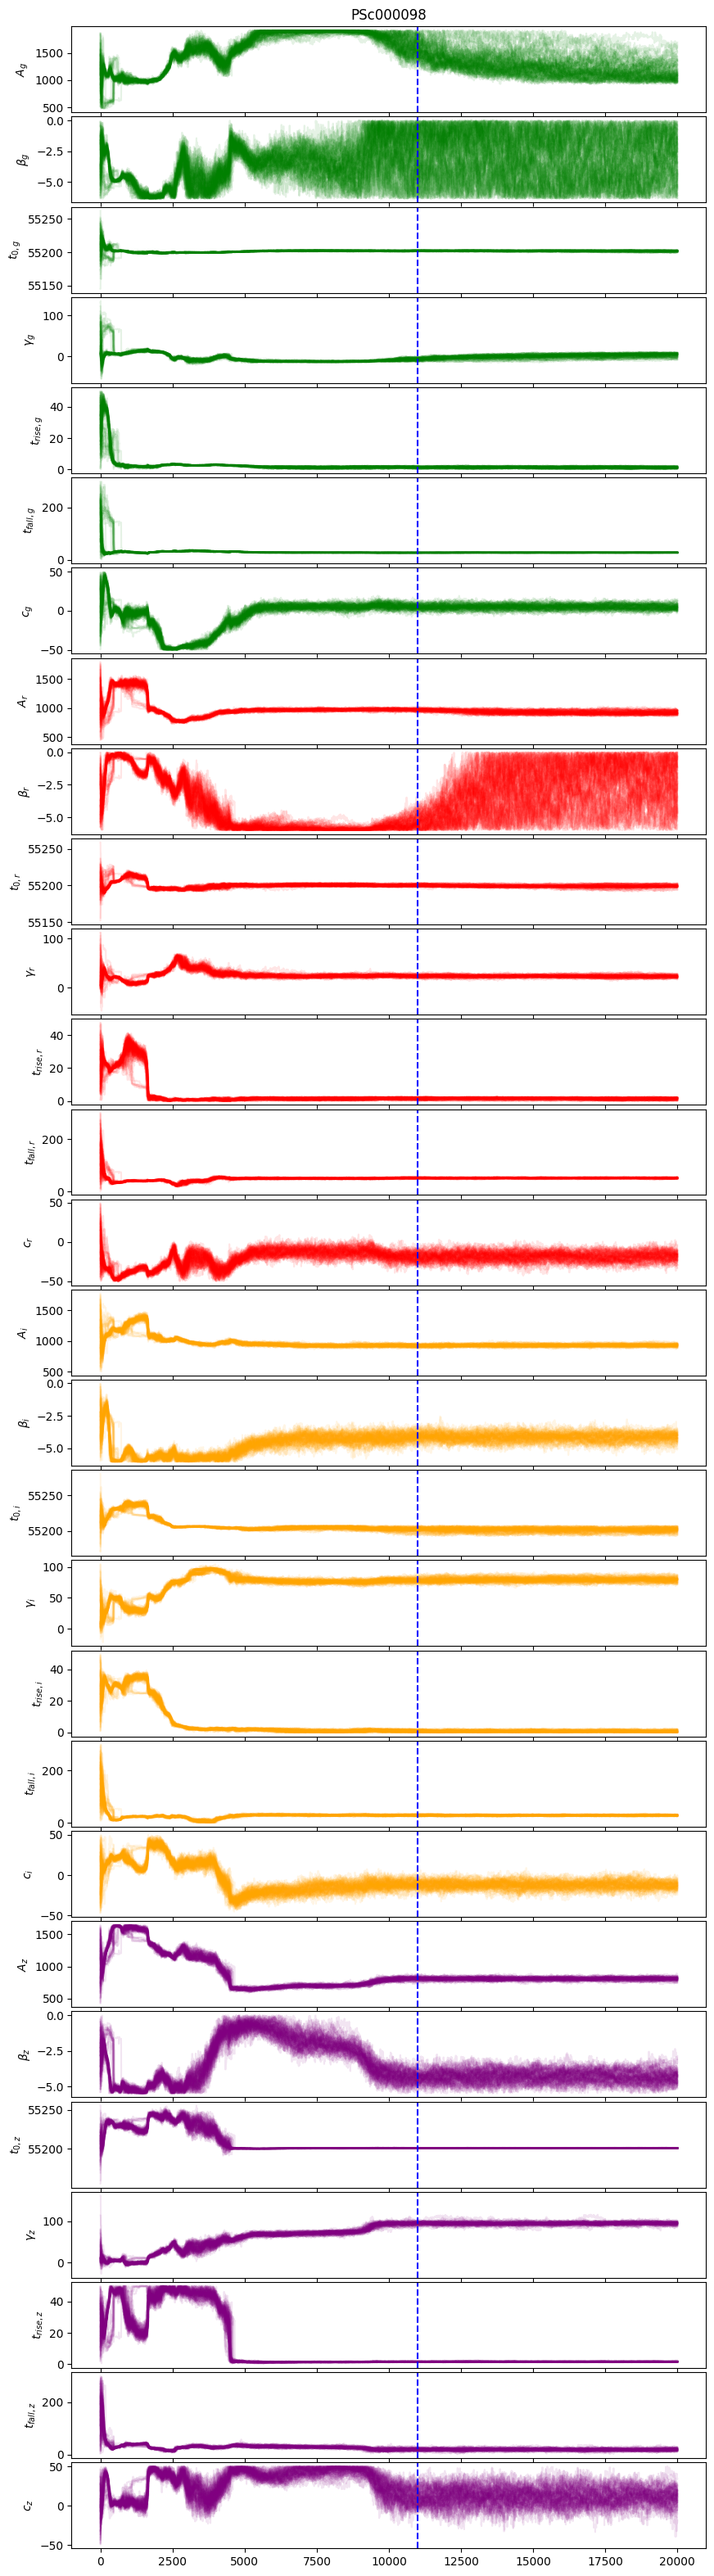

In [10]:
samples = all_samplers[0].get_chain()
nburn = 11000

fig, ax = plt.subplots(samples.shape[2], 1, figsize=(10, .5*samples.shape[1]), sharex=True)
colors = ['g', 'r', 'orange', 'purple']

for i in range(samples.shape[2]):
    for j in range(samples.shape[1]):
        ax[i].plot(samples[:,j,i], c=colors[i//7], alpha=.1)
    
    ax[i].axvline(nburn, ls='--', color='b')
    ax[i].set_ylabel(titles_tot[i//7][i%7])

ax[0].set_title(all_sn[0].objname)
    
plt.subplots_adjust(hspace=.05)
plt.show()

### Corner plot

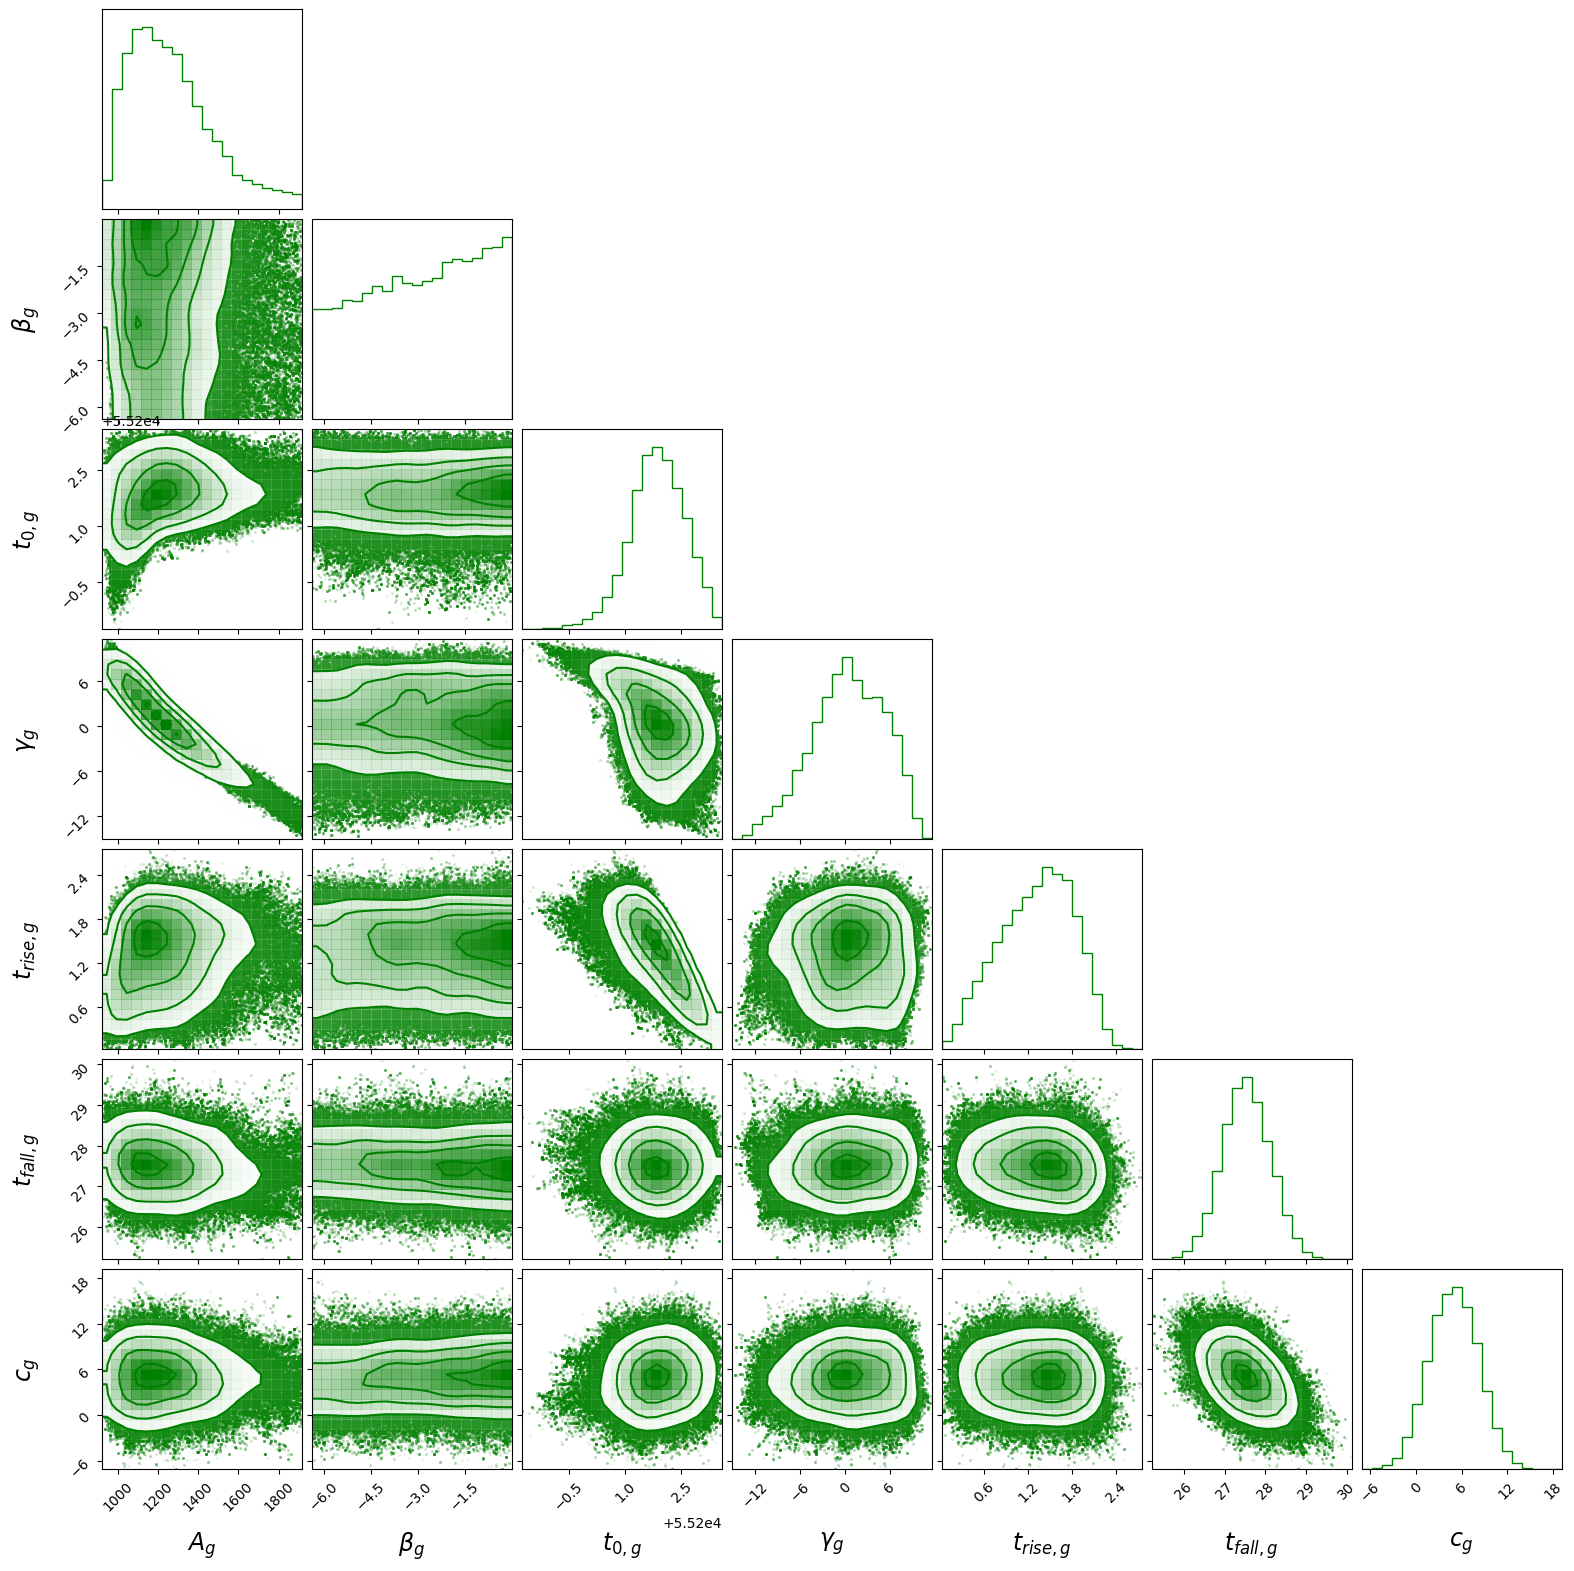

In [11]:
#For the g-band of object 1
i = 0
ind1 = 7*i
ind2 = 7*(i+1)
corner.corner(all_samplers[0].get_chain(flat=True, discard=nburn)[:, ind1:ind2],
              plot_contours=True, smooth=1,
              labels=titles_tot[i], color=colors[i],
              label_kwargs={'fontsize':17});

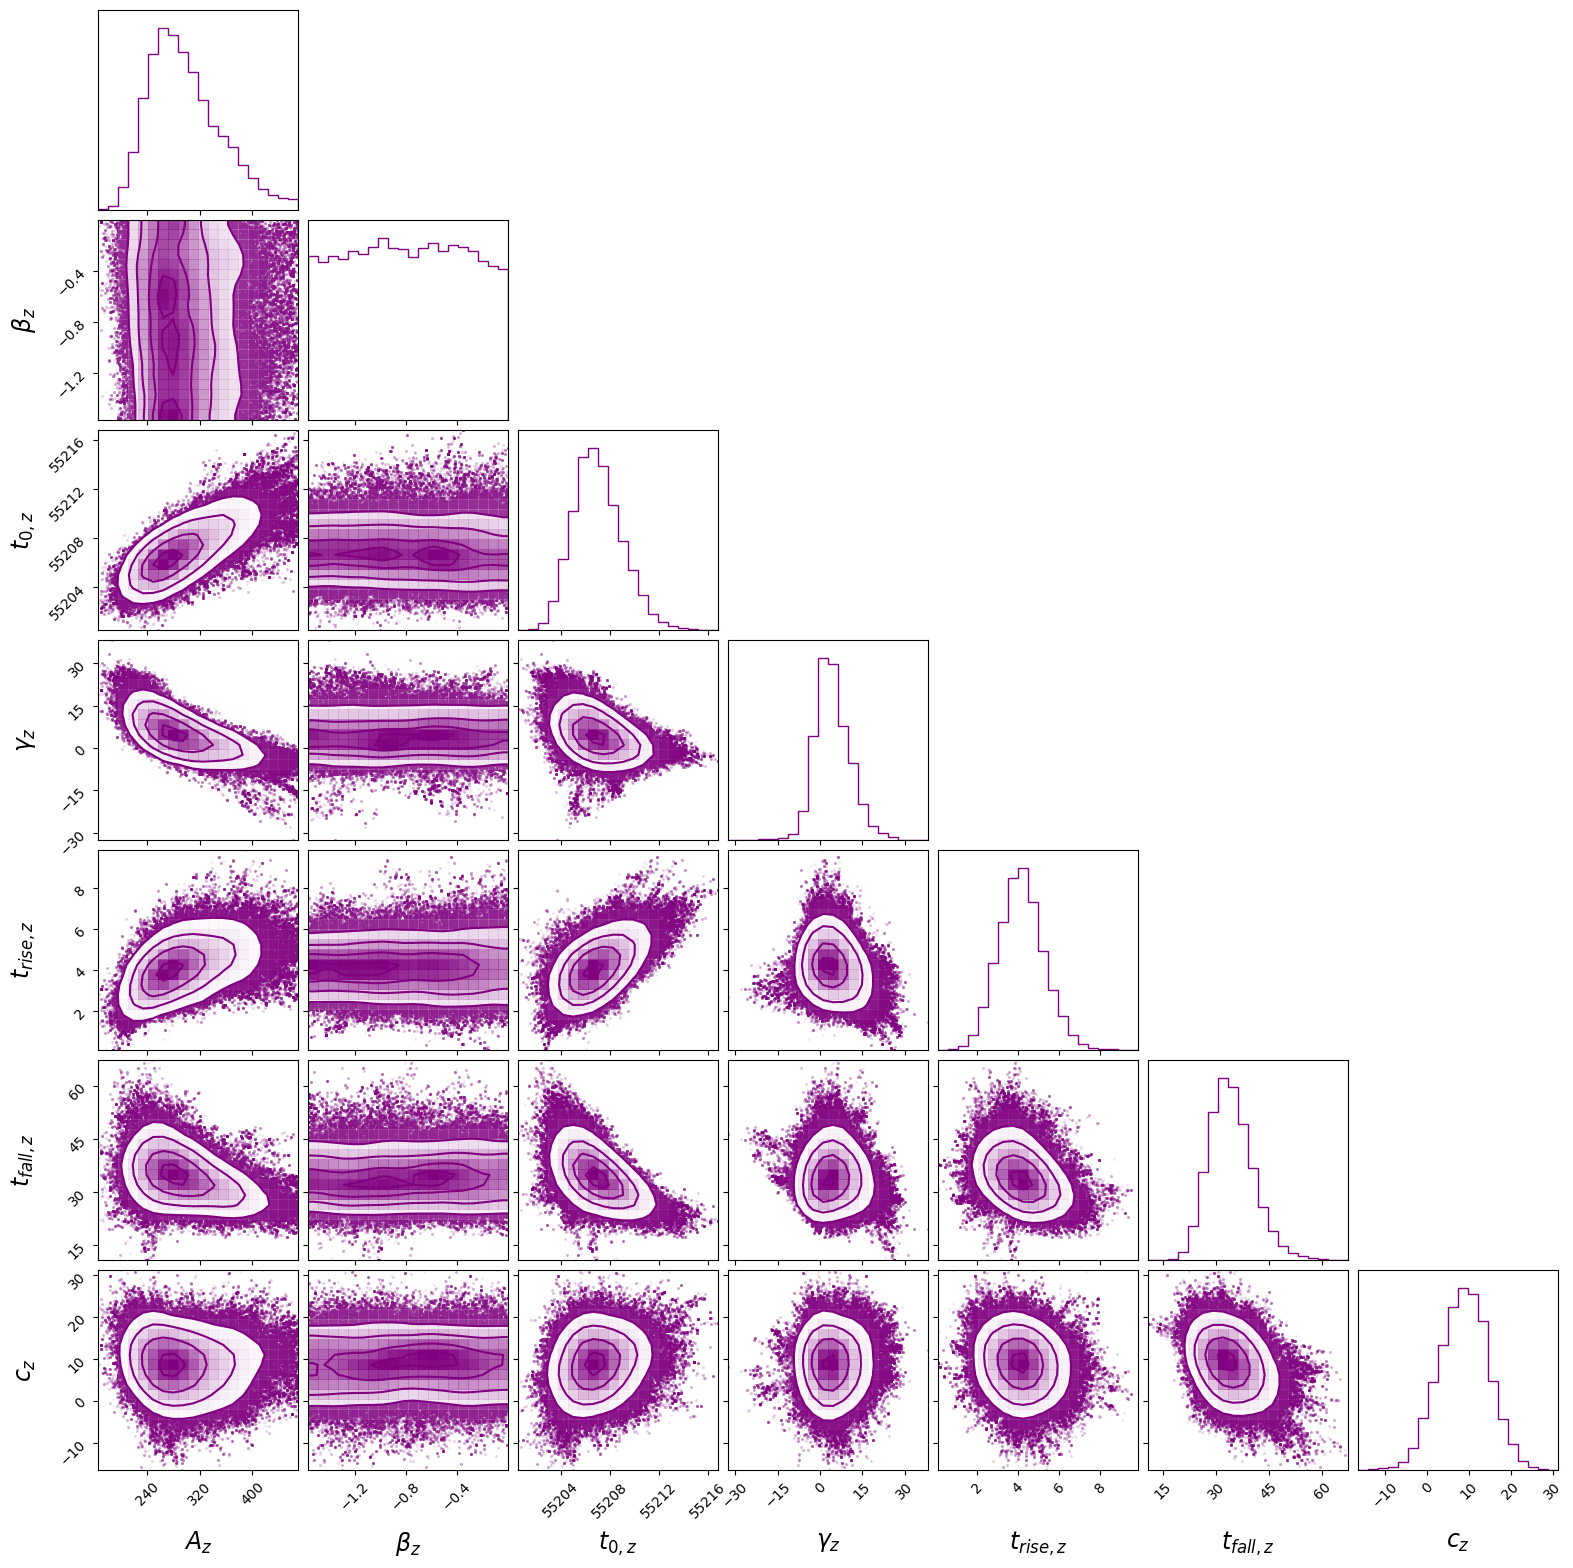

In [54]:
#For the z-band of object 2
i = 3
ind1 = 7*i
ind2 = 7*(i+1)
corner.corner(all_samplers[1].get_chain(flat=True, discard=nburn)[:, ind1:ind2],
              plot_contours=True, smooth=1,
              labels=titles_tot[i], color=colors[i],
              label_kwargs={'fontsize':17});

### Median parameter estimates

In [60]:
band_col = []
obj_col = []
a_col = []
beta_col = []
t0_col = []
gamma_col = []
t_rise_col = []
t_fall_col = []
c_col = []

for j in range(2):
    samples_i = all_samplers[j].get_chain().copy()
    samples_i = samples_i[nburn:,:,:].reshape(-1, samples_i.shape[2])
    
    for i, band in enumerate('griz'):
        
        band_col.append(band)
        obj_col.append(j)
        
        m = 7*i
        
        a_col.append( np.median(samples_i[:,m]) )
        beta_col.append( np.median(samples_i[:,m+1]) )
        t0_col.append( np.median(samples_i[:,m+2]) )
        gamma_col.append( np.median(samples_i[:,m+3]) )
        t_rise_col.append( np.median(samples_i[:,m+4]) )
        t_fall_col.append( np.median(samples_i[:,m+5]) )
        c_col.append( np.median(samples_i[:,m+6]) )
        


res_table = Table()

res_table['object'] = obj_col
res_table['band'] = band_col
res_table['A'] = a_col
res_table['beta'] = beta_col
res_table['t0'] = t0_col
res_table['gamma'] = gamma_col
res_table['t_rise'] = t_rise_col
res_table['t_fall'] = t_fall_col
res_table['c'] = c_col


for col in res_table.colnames:
    if (col == 'object') or (col == 'band'):
        continue
        
    res_table[col].format = '.3f'

res_table

object,band,A,beta,t0,gamma,t_rise,t_fall,c
int64,str1,float64,float64,float64,float64,float64,float64,float64
0,g,1229.485,-2.794,55201.854,0.446,1.350,27.515,4.918
0,r,932.993,-2.880,55199.076,23.652,1.605,51.378,-18.290
0,i,930.367,-4.138,55201.919,78.993,0.725,29.006,-12.078
0,z,810.073,-4.297,55201.043,95.126,1.514,18.840,11.764
1,g,265.419,-0.927,55206.021,13.604,3.047,9.163,4.601
1,r,392.893,-0.989,55209.532,5.274,4.534,19.433,4.421
1,i,440.098,-1.074,55209.764,5.360,4.802,24.539,1.511
1,z,289.313,-0.787,55206.855,3.803,4.140,33.809,8.870


### Model fit plot

In [14]:
def make_bestfit_plot(sampler, sn, nburn, ndim, nsamp=5):

    colors = ['g', 'r', 'orange', 'purple']
    
    samples_og = sampler.get_chain()
    
    #Discard nburn
    samples_tot = samples_og[nburn:, :, :].copy()
    
    #Flatten
    samples_tot = samples_tot.reshape( (-1, samples_tot.shape[2]) ).copy()
    
    #Sample indices to plot (randomly)
    sample_ind = np.random.randint(0, samples_tot.shape[0], size=nsamp)

    t0_g = np.median(samples_tot[:,2])

    fig, ax = plt.subplots()

    for i, band in enumerate('griz'):
        sn.get_band(band)
        sn.cut_times()
        
        band_samples = samples[:, ndim*i:ndim*(i+1)]
        
        
        bestfit_c = np.median(band_samples[:,-1])
        ax.errorbar(sn.x_band-t0_g, sn.y_band, yerr=sn.yerr_band, fmt='.', color=colors[i], mec='k', label=band)

        for j in sample_ind:
            t_samp = np.linspace( t0_g-100, t0_g+200, 1000 )
            bestfit_flux = flux_model(t_samp, samples_tot[j,ndim*i:ndim*(i+1)]) - samples_tot[j,ndim*i -1]

            ax.plot(t_samp-t0_g, bestfit_flux, color=colors[i], alpha=0.5)

    ax.set_xlabel('MJD - $t_{0,g}$')
    ax.set_ylabel('Flux')


    ax.set_xlim(-50, 100)
    ax.set_title(sn.objname)

    ax.legend(loc='upper right')
    plt.show()

    return

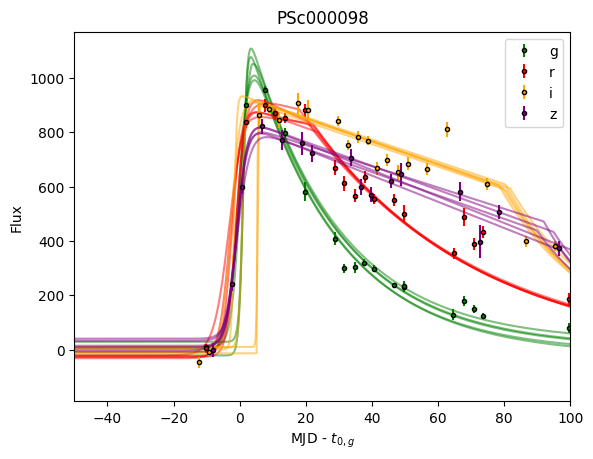

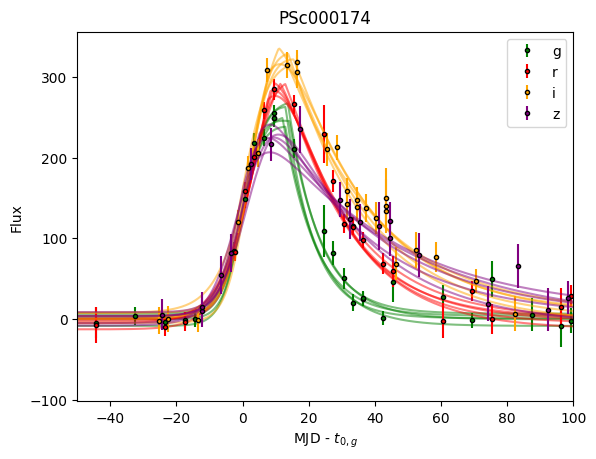

In [15]:
for i in range(2):
    make_bestfit_plot(all_samplers[i], all_sn[i], nburn, ndim=7, nsamp=5)

### Get autocorrelation time

In [50]:
for i in range(2):
    
    #Get samples
    samples_og = all_samplers[i].get_chain().copy()
    
    #Discard burn-in
    samples = samples_og[nburn:, :, :].copy()
    samples_thin = samples_og[nburn::10, :, :].copy()
    
    #Flatten
    samples = samples.reshape( (-1, samples.shape[2]) ).copy()
    samples_thin = samples_thin.reshape( (-1, samples_thin.shape[2]) ).copy()

    tau1 = emcee.autocorr.integrated_time(samples)[0]
    tau2 = emcee.autocorr.integrated_time(samples_thin)[0]
    
    print(all_sn[i].objname)
    print('No thinning: ACF length = {:.4f}'.format(tau1) )
    print('With thinning: ACF length = {:.4f}'.format(tau2)  )
    print('')
    

PSc000098
No thinning: ACF length = 1.7170
With thinning: ACF length = 1.7188

PSc000174
No thinning: ACF length = 0.9685
With thinning: ACF length = 0.9690



The autocorrelation is slightly higher when the chain is thinned by a factor of 10. This difference is smaller than expected, but may be due to the large amount of burn-in samples that I cut. It could also be due to my incorrect use of ``emcee``'s autocorrelation time function.